Topic:        Challenge Set 1
Subject:      Explore MTA turnstile data
Date:         01/16/2018
Name:         Matias Beeck

In [1]:
from __future__ import division, print_function

# MTA Data Challenges

In [2]:
import csv
import pandas as pd
from datetime import datetime
from collections import Counter

### Challenge 1

#### Make key for each row by C/A UNIT SCP and STATION

In [3]:
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150627.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.0M    0 24.0M    0     0  4927k      0 --:--:--  0:00:05 --:--:-- 5077k


In [4]:
with open('turnstile_150627.txt') as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]

In [5]:
assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                       'EXITS']

In [6]:
new_key_dictionary = {}
for row in rows:
    # why does our key have a tuple ? 
    new_key_dictionary.setdefault(tuple(row[:4]), []).append(tuple(row[4:]))
    

In [7]:
# Another way to do the same thing .. 

from collections import defaultdict
t=defaultdict(list)

for row in rows:
    t[tuple(row[:4])].append(tuple(row[4:]))

### Challenge 2

In [8]:
# create a dict comprehension using list comprehension
datetime_cumulative = {turnstile: [(datetime.strptime(date + time,
                                                      '%m/%d/%Y%X'),
                                    int(in_cumulative))
                                   for _, _, date, time,
                                       _, in_cumulative, _ in rows]
                       for turnstile, rows in new_key_dictionary.items()}

In [9]:
# sort by date
for rows in datetime_cumulative.values():
    assert rows == sorted(rows)

In [10]:
datetime_count_times = {turnstile: [[rows[i][0], # datetime first
                                      # delta on entries
                                     rows[i+1][1] - rows[i][1],
                                     # delta on datetime
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative.items()}

In [11]:
all_counts = [count for rows in datetime_count_times.values() for _, count, _ in rows]
all_counts.sort()
print(all_counts[-50:])

[2428, 2443, 2444, 2447, 2448, 2455, 2456, 2459, 2473, 2474, 2487, 2492, 2514, 2521, 2536, 2548, 2552, 2554, 2558, 2567, 2569, 2579, 2602, 2612, 2621, 2622, 2630, 2630, 2644, 2656, 2670, 2671, 2692, 2728, 2731, 2757, 2765, 2804, 2844, 2848, 2920, 2926, 2926, 3488, 87577, 130932, 131711, 131792, 531430, 117440499]


In [12]:
print(all_counts[:10])

[-1208464910, -8664797, -7691983, -1958436, -1283643, -531174, -131370, -131215, -130432, -87562]


In [13]:
# Time intervals? 

all_times = [duration.total_seconds() / 60 / 60
             for rows in datetime_count_times.values()
             for _, _, duration in rows]
print(Counter(all_times).most_common(10))

[(4.0, 172791), (4.2, 10460), (8.0, 189), (4.433333333333334, 161), (0.02222222222222222, 80), (0.02277777777777778, 64), (0.022500000000000003, 55), (0.02777777777777778, 26), (3.963888888888889, 24), (0.03611111111111111, 24)]


In [14]:
datetime_counts = {turnstile: [(time, count)
                               for (time, count, _) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in datetime_count_times.items()}


`datetime_counts` is a solution to Challenge 2.

In [15]:
all_good_counts = [count for rows in datetime_counts.values() for _, count in rows]
print(len(all_good_counts) / len(all_counts))

0.9941598540495402


In [16]:
all_good_counts.sort()
print(all_good_counts[-5:])

[2848, 2920, 2926, 2926, 3488]


In [17]:
print(all_good_counts[:5])

[0, 0, 0, 0, 0]


In [18]:
list(datetime_counts.items())[0]

(('A002', 'R051', '02-00-00', 'LEXINGTON AVE'),
 [(datetime.datetime(2015, 6, 20, 0, 0), 50),
  (datetime.datetime(2015, 6, 20, 4, 0), 18),
  (datetime.datetime(2015, 6, 20, 8, 0), 102),
  (datetime.datetime(2015, 6, 20, 12, 0), 216),
  (datetime.datetime(2015, 6, 20, 16, 0), 364),
  (datetime.datetime(2015, 6, 20, 20, 0), 159),
  (datetime.datetime(2015, 6, 21, 0, 0), 26),
  (datetime.datetime(2015, 6, 21, 4, 0), 26),
  (datetime.datetime(2015, 6, 21, 8, 0), 72),
  (datetime.datetime(2015, 6, 21, 12, 0), 219),
  (datetime.datetime(2015, 6, 21, 16, 0), 233),
  (datetime.datetime(2015, 6, 21, 20, 0), 124),
  (datetime.datetime(2015, 6, 22, 0, 0), 11),
  (datetime.datetime(2015, 6, 22, 4, 0), 44),
  (datetime.datetime(2015, 6, 22, 8, 0), 219),
  (datetime.datetime(2015, 6, 22, 12, 0), 303),
  (datetime.datetime(2015, 6, 22, 16, 0), 909),
  (datetime.datetime(2015, 6, 22, 20, 0), 252),
  (datetime.datetime(2015, 6, 23, 0, 0), 23),
  (datetime.datetime(2015, 6, 23, 4, 0), 62),
  (datetime.

### Challenge 3

In [19]:
# dictionary of dictionaries
day_counts = {}
for turnstile, rows in datetime_counts.items():
    by_day = {}
    for time, count in rows:
        day = time.date()
        by_day[day] = by_day.get(day, 0) + count
    day_counts[turnstile] = sorted(by_day.items())
    

list(day_counts.items())[0]

(('A002', 'R051', '02-00-00', 'LEXINGTON AVE'),
 [(datetime.date(2015, 6, 20), 909),
  (datetime.date(2015, 6, 21), 700),
  (datetime.date(2015, 6, 22), 1738),
  (datetime.date(2015, 6, 23), 1791),
  (datetime.date(2015, 6, 24), 2043),
  (datetime.date(2015, 6, 25), 2190),
  (datetime.date(2015, 6, 26), 1596)])

In [20]:
# dictionary of dictionaries
day_counts = {}
for turnstile, rows in datetime_counts.items():
    by_day = defaultdict(int)
    for time, count in rows:
        day = time.date()
        by_day[day] +=count
    day_counts[turnstile] = sorted(by_day.items())
    

list_rockawayblvd = list(day_counts['N135', 'R385', '01-03-00', 'ROCKAWAY BLVD'])
list_rockawayblvd

[(datetime.date(2015, 6, 20), 271),
 (datetime.date(2015, 6, 21), 201),
 (datetime.date(2015, 6, 22), 561),
 (datetime.date(2015, 6, 23), 543),
 (datetime.date(2015, 6, 24), 555),
 (datetime.date(2015, 6, 25), 556),
 (datetime.date(2015, 6, 26), 543)]

### Challenge 4

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
dates = [i[0] for i in list_rockawayblvd]
counts = [i[1] for i in list_rockawayblvd]


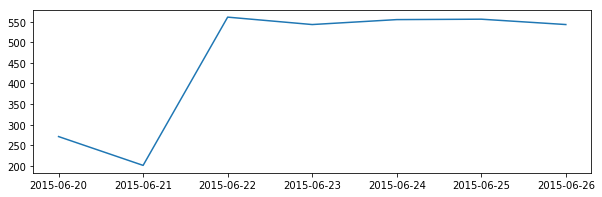

In [22]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

### Challenge 5

In [23]:
with open('turnstile_150627.txt') as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]
assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                       'EXITS']    

In [24]:
from collections import defaultdict
caunitstation=defaultdict(list)
    
CA = []
UNIT = []
STATION = []

for row in rows:
    CA.append(row[0])
    UNIT.append(row[1])
    STATION.append(row[3])

tuples_list = list(zip(CA, UNIT, STATION))
for idx, row in enumerate(rows):
    caunitstation[tuple(tuples_list[idx])].append(tuple(row[4:]))
    

In [25]:
datetime_cumulative_caunitstation = {turnstile: [(datetime.strptime(date + time,
                                                      '%m/%d/%Y%X'),
                                    int(in_cumulative))
                                   for _, _, date, time,
                                       _, in_cumulative, _ in rows]
                       for turnstile, rows in caunitstation.items()}


In [26]:
datetime_caunitstation_count_times = {turnstile: [[rows[i][0], # datetime first
                                      # delta on entries
                                     rows[i+1][1] - rows[i][1],
                                     # delta on datetime
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative_caunitstation.items()}

In [27]:
for key, value in datetime_caunitstation_count_times.items():
    for idx, arr in enumerate(value):
        if arr[1] > 5000:
            del value[idx]

In [28]:
all_counts = [count for rows in datetime_caunitstation_count_times.values() for _, count, _ in rows]
all_times = [duration.total_seconds() / 60 / 60
             for rows in datetime_caunitstation_count_times.values()
             for _, _, duration in rows]

In [29]:
datetime_caunitstation_counts = {turnstile: [(time, count)
                               for (time, count, _) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in datetime_caunitstation_count_times.items()}
all_good_counts = [count for rows in datetime_caunitstation_counts.values() for _, count in rows]


In [30]:
# dictionary of dictionaries
day_counts = {}
for turnstile, rows in datetime_caunitstation_counts.items():
    by_day = defaultdict(int)
    for time, count in rows:
        day = time.date()
        by_day[day] +=count
    day_counts[turnstile] = sorted(by_day.items())
    
list(day_counts.items())[0]    

(('A002', 'R051', 'LEXINGTON AVE'),
 [(datetime.date(2015, 6, 20), 10606),
  (datetime.date(2015, 6, 21), 7952),
  (datetime.date(2015, 6, 22), 17199),
  (datetime.date(2015, 6, 23), 18000),
  (datetime.date(2015, 6, 24), 18585),
  (datetime.date(2015, 6, 25), 18664),
  (datetime.date(2015, 6, 26), 15392)])

### Challenge 6

In [31]:
with open('turnstile_150627.txt') as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]
assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                       'EXITS']    

In [32]:
station_list=defaultdict(list)

for idx, row in enumerate(rows):
    station_list[STATION[idx]].append(tuple(row[4:]))
    

In [33]:
datetime_cumulative_station = {turnstile: [(datetime.strptime(date + time,
                                                      '%m/%d/%Y%X'),
                                    int(in_cumulative))
                                   for _, _, date, time,
                                       _, in_cumulative, _ in rows]
                       for turnstile, rows in station_list.items()}


In [34]:
datetime_station_count_times = {turnstile: [[rows[i][0], # datetime first
                                      # delta on entries
                                     rows[i+1][1] - rows[i][1],
                                     # delta on datetime
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative_station.items()}

In [35]:
for key, value in datetime_station_count_times.items():
    for idx, arr in enumerate(value):
        if arr[1] > 5000:
            del value[idx]

In [36]:
all_counts = [count for rows in datetime_station_count_times.values() for _, count, _ in rows]
all_times = [duration.total_seconds() / 60 / 60
             for rows in datetime_station_count_times.values()
             for _, _, duration in rows]

In [37]:
datetime_station_counts = {turnstile: [(time, count)
                               for (time, count, _) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in datetime_station_count_times.items()}
all_good_counts = [count for rows in datetime_station_counts.values() for _, count in rows]


In [38]:
# dictionary of dictionaries
day_counts_week1 = {}
for turnstile, rows in datetime_station_counts.items():
    by_day = defaultdict(int)
    for time, count in rows:
        day = time.date()
        by_day[day] +=count
    day_counts_week1[turnstile] = sorted(by_day.items())
    
lex_ave_date_list = list(day_counts_week1['LEXINGTON AVE'])
lex_ave_date_list

[(datetime.date(2015, 6, 20), 14161),
 (datetime.date(2015, 6, 21), 10177),
 (datetime.date(2015, 6, 22), 29344),
 (datetime.date(2015, 6, 23), 31095),
 (datetime.date(2015, 6, 24), 31155),
 (datetime.date(2015, 6, 25), 31970),
 (datetime.date(2015, 6, 26), 25534)]

### Challenge 7

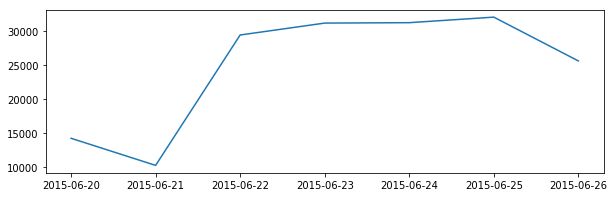

In [39]:
dates = [i[0] for i in lex_ave_date_list]
counts = [i[1] for i in lex_ave_date_list]
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

### Challenge 8

In [40]:
week1_count_list = [x[1] for x in lex_ave_date_list]
week1_count_list


[14161, 10177, 29344, 31095, 31155, 31970, 25534]

In [41]:
# Importing next week
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150704.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.9M    0 23.9M    0     0  1887k      0 --:--:--  0:00:13 --:--:-- 1973k


In [42]:
# Imporitng third week
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150711.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.8M    0 23.8M    0     0  1629k      0 --:--:--  0:00:15 --:--:-- 1712k


In [43]:
# Getting next week
with open('turnstile_150704.txt') as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]

assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                       'EXITS']


In [44]:
station_list=defaultdict(list)
STATION = []
for row in rows:
    STATION.append(row[3])
    
for idx, row in enumerate(rows):
    station_list[STATION[idx]].append(tuple(row[4:]))

In [45]:
datetime_cumulative_station = {turnstile: [(datetime.strptime(date + time,
                                                      '%m/%d/%Y%X'),
                                    int(in_cumulative))
                                   for _, _, date, time,
                                       _, in_cumulative, _ in rows]
                       for turnstile, rows in station_list.items()}


In [46]:
datetime_station_count_times = {turnstile: [[rows[i][0], # datetime first
                                      # delta on entries
                                     rows[i+1][1] - rows[i][1],
                                     # delta on datetime
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative_station.items()}

In [47]:
for key, value in datetime_station_count_times.items():
    for idx, arr in enumerate(value):
        if arr[1] > 5000:
            del value[idx]

all_counts = [count for rows in datetime_station_count_times.values() for _, count, _ in rows]
all_times = [duration.total_seconds() / 60 / 60
             for rows in datetime_station_count_times.values()
             for _, _, duration in rows]

datetime_station_counts = {turnstile: [(time, count)
                               for (time, count, _) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in datetime_station_count_times.items()}
all_good_counts = [count for rows in datetime_station_counts.values() for _, count in rows]


In [48]:
# dictionary of dictionaries
day_counts_week2 = {}
for turnstile, rows in datetime_station_counts.items():
    by_day = defaultdict(int)
    for time, count in rows:
        day = time.date()
        by_day[day] +=count
    day_counts_week2[turnstile] = sorted(by_day.items())
    
lex_ave_date_list = list(day_counts_week2['LEXINGTON AVE'])
lex_ave_date_list

[(datetime.date(2015, 6, 27), 13674),
 (datetime.date(2015, 6, 28), 11333),
 (datetime.date(2015, 6, 29), 29140),
 (datetime.date(2015, 6, 30), 29753),
 (datetime.date(2015, 7, 1), 30018),
 (datetime.date(2015, 7, 2), 29678),
 (datetime.date(2015, 7, 3), 13535)]

In [49]:
week2_count_list = [x[1] for x in lex_ave_date_list]
week2_count_list

[13674, 11333, 29140, 29753, 30018, 29678, 13535]

In [50]:
# Week 3
# Getting next week
with open('turnstile_150711.txt') as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]

assert rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                       'EXITS']


In [51]:
station_list=defaultdict(list)
STATION = []
for row in rows:
    STATION.append(row[3])
    
for idx, row in enumerate(rows):
    station_list[STATION[idx]].append(tuple(row[4:]))

In [52]:
datetime_cumulative_station = {turnstile: [(datetime.strptime(date + time,
                                                      '%m/%d/%Y%X'),
                                    int(in_cumulative))
                                   for _, _, date, time,
                                       _, in_cumulative, _ in rows]
                       for turnstile, rows in station_list.items()}


In [53]:
datetime_station_count_times = {turnstile: [[rows[i][0], # datetime first
                                      # delta on entries
                                     rows[i+1][1] - rows[i][1],
                                     # delta on datetime
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative_station.items()}

In [54]:
for key, value in datetime_station_count_times.items():
    for idx, arr in enumerate(value):
        if arr[1] > 5000:
            del value[idx]

all_counts = [count for rows in datetime_station_count_times.values() for _, count, _ in rows]
all_times = [duration.total_seconds() / 60 / 60
             for rows in datetime_station_count_times.values()
             for _, _, duration in rows]

datetime_station_counts = {turnstile: [(time, count)
                               for (time, count, _) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in datetime_station_count_times.items()}
all_good_counts = [count for rows in datetime_station_counts.values() for _, count in rows]


In [55]:
# dictionary of dictionaries
day_counts_week3 = {}
for turnstile, rows in datetime_station_counts.items():
    by_day = defaultdict(int)
    for time, count in rows:
        day = time.date()
        by_day[day] +=count
    day_counts_week3[turnstile] = sorted(by_day.items())
    
lex_ave_date_list = list(day_counts_week3['LEXINGTON AVE'])
lex_ave_date_list

[(datetime.date(2015, 7, 4), 10873),
 (datetime.date(2015, 7, 5), 9980),
 (datetime.date(2015, 7, 6), 26368),
 (datetime.date(2015, 7, 7), 28438),
 (datetime.date(2015, 7, 8), 29491),
 (datetime.date(2015, 7, 9), 29883),
 (datetime.date(2015, 7, 10), 24311)]

In [56]:
week3_count_list = [x[1] for x in lex_ave_date_list]
week3_count_list


[10873, 9980, 26368, 28438, 29491, 29883, 24311]

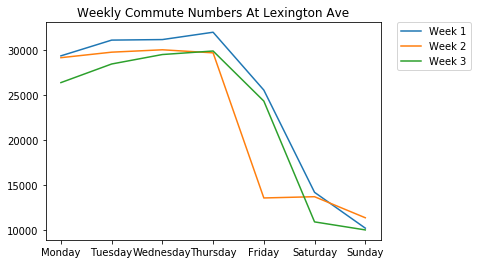

In [57]:
order = [2,3,4,5,6,0,1]
week1_count_list = [week1_count_list[i] for i in order]
week2_count_list = [week2_count_list[i] for i in order]
week3_count_list = [week3_count_list[i] for i in order]
plt.xticks([0,1,2,3,4,5,6],('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.plot(week1_count_list, label="Week 1")
plt.plot(week2_count_list, label="Week 2")
plt.plot(week3_count_list, label="Week 3")
plt.title('Weekly Commute Numbers At Lexington Ave')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



### Challenge 9

In [58]:
# Week1 by stations count
week1_stations_count = {}
for key, value in day_counts_week1.items():
    counts = [x[1] for x in value]
    week1_stations_count[key] = sum(counts)
week1_stations_count

{'1 AVE': 150372,
 '103 ST': 161468,
 '103 ST-CORONA': 122220,
 '104 ST': 14130,
 '110 ST': 89757,
 '110 ST-CATHEDRL': 83346,
 '110 ST-CPN': 63142,
 '111 ST': 84708,
 '116 ST': 213188,
 '116 ST-COLUMBIA': 86000,
 '121 ST': 15399,
 '125 ST': 484018,
 '135 ST': 127894,
 '137 ST-CITY COL': 85403,
 '138 ST-3 AVE': 48208,
 '138 ST-GR CONC': 21280,
 '14 ST': 264096,
 '14 ST-6 AVE': 109569,
 '14 ST-UNION SQ': 684973,
 '145 ST': 235061,
 '148 ST-LENOX': 24608,
 '149 ST-3 AVE': 131569,
 '149 ST-GR CONC': 75368,
 '14TH STREET': 56485,
 '15 ST-PROSPECT': 40804,
 '155 ST': 42455,
 '157 ST': 70545,
 '161 ST-YANKEE': 201658,
 '163 ST-AMSTERDM': 27477,
 '167 ST': 124338,
 '168 ST-BROADWAY': 153903,
 '169 ST': 52835,
 '170 ST': 101465,
 '174 ST': 37386,
 '174-175 ST': 33158,
 '175 ST': 86835,
 '176 ST': 38575,
 '18 AVE': 100154,
 '18 ST': 51801,
 '181 ST': 144654,
 '182-183 ST': 31743,
 '183 ST': 39548,
 '190 ST': 30043,
 '191 ST': 51948,
 '2 AVE': 110996,
 '20 AVE': 54414,
 '207 ST': 41262,
 '21 ST':

In [59]:
# Week2 by stations count
week2_stations_count = {}
for key, value in day_counts_week2.items():
    counts = [x[1] for x in value]
    week2_stations_count[key] = sum(counts)


In [60]:
# Week3 by stations count
week3_stations_count = {}
for key, value in day_counts_week3.items():
    counts = [x[1] for x in value]
    week3_stations_count[key] = sum(counts)


In [61]:
wk123_station_dict = { k: week1_stations_count.get(k, 0) + week2_stations_count.get(k, 0) + week3_stations_count.get(k, 0) for k in set(week1_stations_count) | set(week2_stations_count) | set(week3_stations_count) }

series = pd.Series(wk123_station_dict, name='counts')
series.index.name = 'station'
stationdf = series.reset_index()
stationdf.sort_values(by='counts', ascending = False)

,station,counts
67,34 ST-PENN STA,3183081
72,42 ST-GRD CNTRL,2671217
66,34 ST-HERALD SQ,2145903
18,14 ST-UNION SQ,1958353
113,86 ST,1922237
74,42 ST-TIMES SQ,1859587
73,42 ST-PA BUS TE,1742382
231,FULTON ST,1378181
117,96 ST,1371423
11,125 ST,1366448


### Challenge 10

(array([ 304.,   46.,   17.,    6.,    4.,    2.,    3.,    0.,    1.,    1.]),
 array([    5355. ,   323127.6,   640900.2,   958672.8,  1276445.4,
         1594218. ,  1911990.6,  2229763.2,  2547535.8,  2865308.4,
         3183081. ]),
 <a list of 10 Patch objects>)

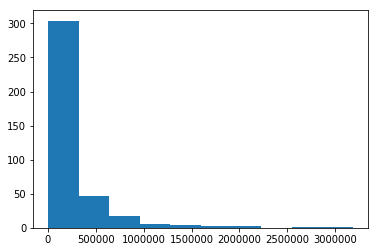

In [62]:
plt.hist(list(stationdf['counts']))